## Radar Specifications

In [1]:
import numpy as np

#---------------------------------------------
# 1 FMCV Waveform design
#---------------------------------------------

# Speed of EM wave in air
c = 3e8 # m/s
# Carrier frequency
fc = 77e9 # Hz

max_range = 200 # m
max_velocity = 100 # m/s

# Range Resolution
delta_r = 1 # m

# Bandwidth
B = c / (2 * delta_r)

# Chrip time
# V_max = wavelength / (4 * Tchrip) -> Tchrip = wavelength / (4 * max_velocity)
Tchirp = 5.5* (max_range * 2 / c)

# Slope of chrips
S = B / Tchirp

# Num of chrips in one sequence. 
# Ideally 2^ for FFT doppler estimation
Nd = 128
# Num of samples of one chirp
Nr = 1024

# Easy ops for half side of FFT
Nr_2 = int(Nr / 2)

## Simulation Setup

In [2]:
#---------------------------------------------
# 2 Simulation loop
#---------------------------------------------

# Target info
# Initial position
d0 = 80
# Initial Velocity
v0 = -50

# Nr * Nd total time slices for samples
t = np.linspace(0, Nd * Tchirp, Nr * Nd)

dim = t.shape[0]

# Pre-allocated mem

# Transmitted Signal
Tx = np.zeros((1, dim))
# Received Signal
Rx = np.zeros((1, dim))
# Beat signal
Mix = np.zeros((1, dim))

R_updated = np.zeros((1, dim))
tau = np.zeros((1, dim))

## Signal Generation and Moving Target Sim

In [3]:
# LOOP
# Vectorized operations

# Simple 1D motion model
R_updated = d0 + v0 * t

# Tau
tau = 2 * R_updated / c

# Update signals for every samples along time axis
Tx = np.cos(2 * np.pi * (fc * t + S * t ** 2 / 2))
Rx = np.cos(2 * np.pi * (fc * (t - tau) + S * (t - tau) ** 2 / 2))

# Freq mixer for generating beat signal (element wise multiplication)
# TODO: Check for element wise operations
Mix = Tx * Rx

## Range Measurement

In [4]:
#---------------------------------------------
# 3 Range FFT
#---------------------------------------------
range_fft = np.fft.fft(Mix, Nr)
range_fft = range_fft / (Nr_2)

# Take the absolute value of FFT output
range_fft = abs(range_fft)
# Output of FFT is double sided signal, but we are interested in only one side of the spectrum.Hence we throw out half of the samples.
range_fft = range_fft[0: Nr_2 - 1]

In [20]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



## Visualize Range FFT

<BarContainer object of 512 artists>

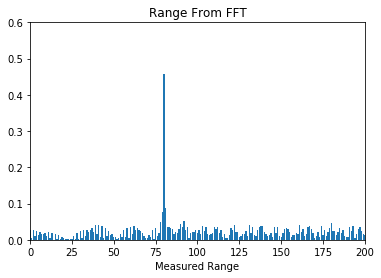

In [26]:
plt.xlim([0, 200])
plt.ylim([0, 0.6])
plt.title('Range From FFT')
plt.xlabel('Measured Range')


x = np.arange(Nr_2).astype(float)

plt.bar(x, range_fft)

## Range Doppler Response

In [27]:
# Range Doppler Generation
Mix = np.reshape(Mix, (Nr, Nd))
sig_fft2 = np.fft.fft2(Mix, (Nr, Nd))

# Shift center
sig_fft2 = np.fft.fftshift(sig_fft2[0: Nr_2 - 1])

# To DB
range_doppler_map = abs(sig_fft2)
range_doppler_map = 10 * np.log10(range_doppler_map)

In [13]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm


In [14]:
# doppler_axis = np.linspace(-100, 100, Nd)
# range_axis = np.linspace(-200, 200, int(Nr/2)) * (int(Nr / 2) / 400)

In [15]:
nx = np.arange(0, doppler_axis.shape[0])
ny = np.arange(0, range_axis.shape[0])

xax, yax = np.meshgrid(nx, ny)


(512, 128)

Text(0.5, 0, 'Measured Doppler')

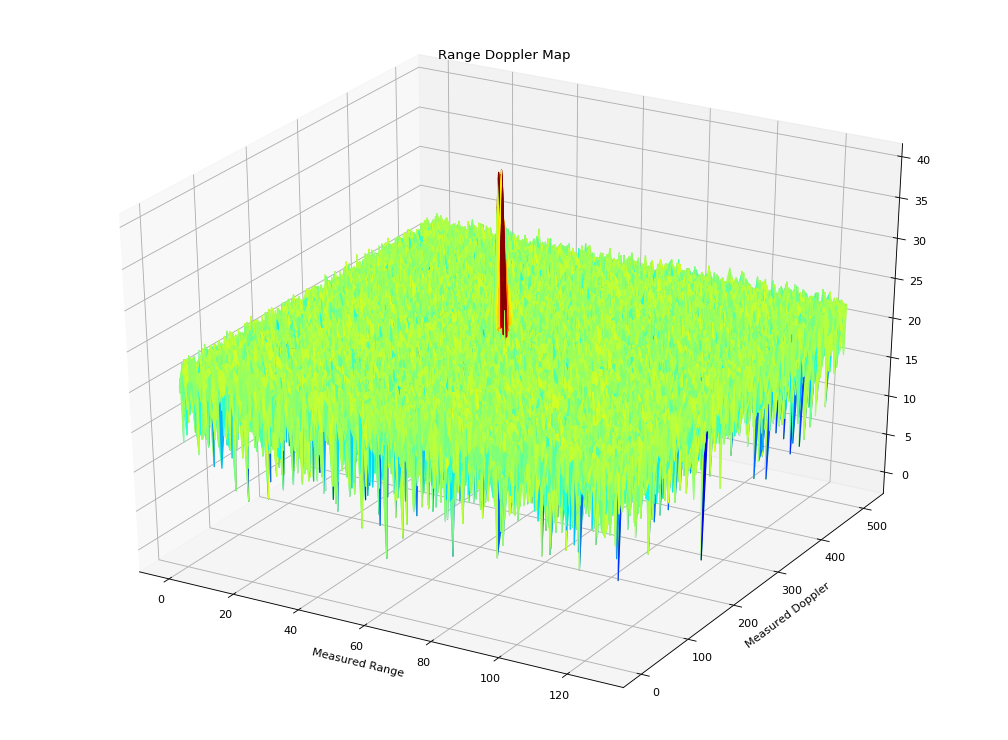

In [30]:
# Surf color map
color_dimension = range_doppler_map # change to desired fourth dimension
minn, maxx = color_dimension.min(), color_dimension.max()
norm = matplotlib.colors.Normalize(minn, maxx)
m = plt.cm.ScalarMappable(norm=norm, cmap='jet')
m.set_array([])
fcolors = m.to_rgba(color_dimension)

fig1 = plt.figure(figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
ax1 = fig1.gca(projection='3d')
surf1 = ax1.plot_surface(xax, yax, range_doppler_map, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

plt.title('Range Doppler Map')
plt.xlabel('Measured Range')
plt.ylabel('Measured Doppler')


In [42]:
def pow2db(x):
    """returns the corresponding decibel (dB) value for a power value x.

    The relationship between power and decibels is:

    .. math::    X_{dB} = 10 * \log_{10}(x)

    .. doctest::

        >>> from spectrum import pow2db
        >>> x = pow2db(0.1)
        >>> x
        -10.0
    """
    return 10 * np.log10(x)



def db2pow(xdb):
    """Convert decibels (dB) to power

    .. doctest::

        >>> from spectrum import db2pow
        >>> p = db2pow(-10)
        >>> p
        0.1

    .. seealso:: :func:`pow2db`
    """
    return 10.**(xdb/10.)

## CFAR Implementation


Design a loop such that it slides the CUT across range doppler map by
giving margins at the edges for training and guard cells.

For every iteration sum the signal level within all the training cells.

To sum convert the value from logarithmic to linear using the db2pow function.

Average the summed values for all of the training cells used.

After averaging convert it back to logarithimic using pow2db.

Further, add the offset to it to determine the threshold. Next, compare the signal under
CUT with this threshold.

If the CUT level > threshold assign it a value of 1, else equate it to 0.

In [55]:
# Select the number of training cells in both dimensions
# Training (range dim)
Tr = 12
# Traning cells (doppler dim)
Td = 3

# Select the number of guard cells in both dimensions around the Cell Under
# Test (CUT) for accurate estimation.
# Guard celles (range dim)
Gr = 4
Gd = 1

# Offset the threshold by SNR value in dB
SNR_offset = 10
# Calculate the total number of training and guard cells
# Remove CUT
N_guard = (2 * Gr + 1) * (2 * Gd + 1) - 1
N_training = (2 * Tr + 2 * Gr + 1) * (2 * Td + 2 * Gd + 1) - (N_guard + 1)

# RDM_pow = db2pow(range_doppler_map)
# noise_level = np.zeros()
RDM = range_doppler_map
CFAR = np.zeros(RDM.shape)

### Sliding window

In [56]:
# There is a fancy way to do sliding window on numpy array
# https://jessicastringham.net/2017/12/31/stride-tricks/


for range_index in range(Tr + Gr, Nr_2 - 1 - Tr - Gr):
    for doppler_index in range(Td + Gd, Nd - 1 - Td - Gd):
        training = RDM[range_index - Tr - Gr : range_index + Tr + Gr, doppler_index - Td - Gd : doppler_index + Td + Gd]
        # Zero all non training cells
        training[range_index - Gr : range_index + Gr, doppler_index - Gd : doppler_index + Gd] = 0
        training = db2pow(training)
        # Calc average energy (power) within training window
        training = np.sum(training) / N_training
        training = pow2db(training)
        # use offset to determine SNR threshold
        threshold = training + SNR_offset
        # Apply the threashold to the CUT
        # Binary binning
        if RDM[range_index][doppler_index] > threshold:
            CFAR[range_index][doppler_index] = 1
        
        

Notes: Playwith SNR_offset, if no signal or too much noise is picked

Text(0.5, 0, 'Measured Doppler')

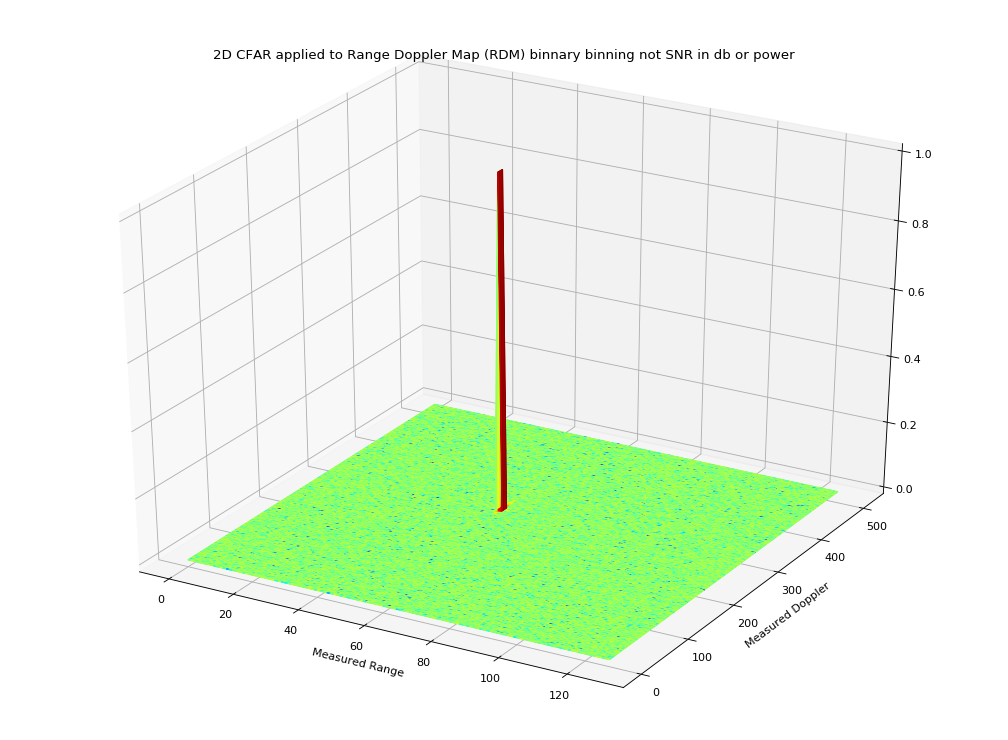

In [60]:
fig2 = plt.figure(figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
ax2 = fig2.gca(projection='3d')
surf2 = ax2.plot_surface(xax, yax, CFAR, rstride=1, cstride=1, facecolors=fcolors, vmin=minn, vmax=maxx, shade=False)

plt.title('2D CFAR applied to Range Doppler Map (RDM) binnary binning not SNR in db or power')
plt.xlabel('Measured Range')
plt.ylabel('Measured Doppler')